In this tutorial we will use the basic functionallity of EMCEE (the MCMC software) to fit a synthetic binary that we make using phoebe.

In [1]:
%matplotlib inline 
import numpy as np
import emcee
import matplotlib.pyplot as pl
import phoebe
from matplotlib.pyplot import cm 
from scipy.stats import norm

First we make our synthetic data, this time we will make a binary star using PHOEBE and add noise:

In [2]:
b = phoebe.default_binary()
#phoebe.mpi_off() #This needs to be off so that it doesn't interfere with emcee's parrallizing.

First we will add a light curve data set so that we cam make our synthetic data model:

In [3]:
times = np.linspace(0,3,201)
b.add_dataset('lc', times=times, dataset='lc01')

<ParameterSet: 19 parameters | contexts: dataset, constraint, compute>

We will set the irradiation method to "none" (for the purpose of the tutorial) as that requires significant computational time:

In [4]:
b.get_parameter(context='compute', qualifier='irrad_method').set_value("none")

We will also significantly reduce the number of triangles to speed up computations:

In [5]:
b.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)

In [6]:
b.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

We will set the parameters that we plan to fit to specific values:

In [7]:
b['incl@binary@orbit@component'] = 86.5
b['requiv@primary@star@component'] = 1.2
b['requiv@secondary@star@component'] = 0.8
b['q@binary@orbit@component'] = 0.7
b['pblum@primary@dataset'] = 2.9*np.pi

Now we will compute our phoebe model, add noise and plot the results:

In [8]:
b.run_compute()

<ParameterSet: 2 parameters | qualifiers: times, fluxes>

In [9]:
fluxes = b['fluxes@latest@model'].get_value()
sigmas = np.full((len(times)), 0.01)
mean = 0.0
noise = np.random.normal(mean, sigmas, fluxes.shape)
noisy = fluxes + noise

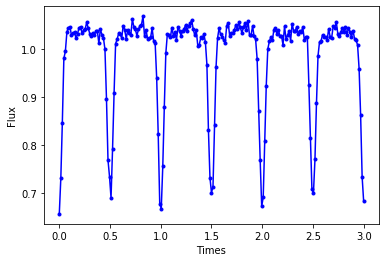

In [10]:
pl.plot(times, noisy, "b.-")
pl.xlabel("Times")
pl.ylabel("Flux")
pl.show()

Now we have our data, we need to set the hyperparamters required to run emcee. Here the prior boxes provide the lower and upper limits for the phoebe parameter values. We will select the order to be incl, requiv1, requiv2, mass ratio:

In [11]:
nwalkers = 10
niter = 2
init_dist = [(86.4,87.3),(1.15,1.25),(0.725,0.825),(0.675,0.725)]

Now we will set up some prior information. If we know something about our system, say from spectra, we can inform our model by setting priors. Here we will set uninformed priors, but you can have informed priors such as gaussian priors:

In [12]:
priors = [(80.,90),(1.1,1.3),(0.7,0.9),(0.6,0.9)]

Now we will set up a new bundle, which we will call "mod", to compute the model to fit the synthetic data we just generated:

In [13]:
mod = phoebe.default_binary()

We will generate the model with less data points than our data in phase space. This is only recommended for data that doesn't have a changing orbital period.

In [14]:
mod.add_dataset('lc', times = times, fluxes=fluxes, sigmas=sigmas,compute_phases=np.linspace(0,1.,51), passband='Kepler:mean')


<ParameterSet: 19 parameters | contexts: dataset, constraint, compute>

Again, for the purpose of speeding up computations we will set the number of triangles to a (ridiciously) low value and turn off reflection:

In [15]:
mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

Since we have a dataset, we can add the helper function that calculates the passband luminosity at each iteration instead of fitting for it:

In [16]:
mod.set_value('pblum_mode',value='dataset-scaled')

Generate an initial guess for all the parameters by drawing from initial distributions:

In [17]:
def rpars(init_dist):
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

Instate the priors such that if a parameter falls outside the prior range, the value will be set to negative infinity and the model will not be accepted:

In [18]:
def lnprior(priors, values):
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

Now we will specify our log probability function, which will include our likelihood computation and our logprior value. Here, z will be the array of values returned by the mcmc algorithm. We will update the parameter values with the new values given by the mcmc fitter in this function and then recompute the model. In this example, the lnp value will be zero or negative infinity, but if a gaussain prior is used, this will become a value.

In [19]:
def lnprob(z):

    mod['incl@binary@orbit@component'] = z[0]
    mod['requiv@primary@star@component'] = z[1]
    mod['requiv@secondary@star@component'] = z[2]
    mod['q@binary@orbit@component'] = z[3]
    
    lnp = lnprior(priors,z)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        mod.run_compute()

        # use chi^2 to compare the model to the data:
        chi2 = 0.
        for dataset in mod.get_model().datasets:
            chi2+=np.sum(mod.compute_residuals(dataset=dataset, as_quantity=False)**2/sigmas**2)
        # calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf

Now we will set the run function which will combine all our computations:

In [20]:
def run(init_dist, nwalkers, niter):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(init_dist) for i in range(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. With this setup, the value z
    # in the lnprob function, is the output from the sampler.
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob)
    
    #pos is the position of the walkers in parameter space
    #prob is the probability of the given "pos" positions
    #state is the state of the random number generator
    pos, prob, state = sampler.run_mcmc(p0, niter)

    for i in range(ndim):
        pl.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = pl.hist(y, 200, density=1, color="b", alpha=0.45)#, histtype="step")
        pl.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print("mu = ", mu)
        print("sigma = ",sigma)

        bf = norm.pdf(bins, mu, sigma)
        l = pl.plot(bins, bf, 'k--', linewidth=2.0)
    pl.show()
    return pos

mu =  86.80013129619596
sigma =  0.1342927216596835
mu =  1.188154660377467
sigma =  0.017768805042185785
mu =  0.7762183376266433
sigma =  0.02075683787492112
mu =  0.6899243320801386
sigma =  0.016751409065570242


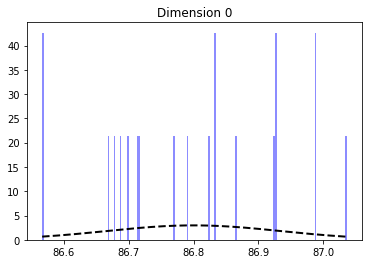

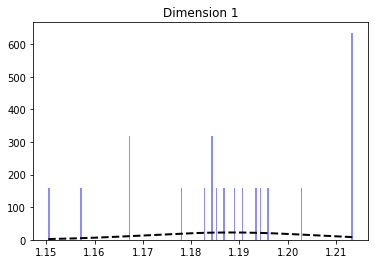

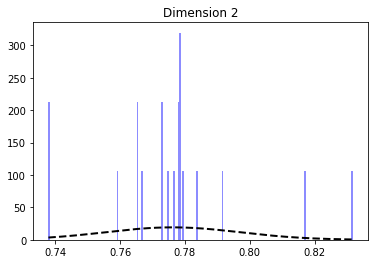

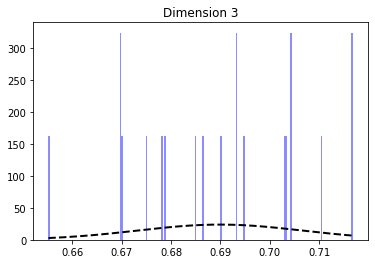

In [21]:
pos = run(init_dist, nwalkers, niter)

If we wish to see how good our last fit was, we can overplot the final models and the synthetic data. To do this, we will need to update the model with the last parameter values from our fit, and then overplot each one:

In [22]:
color=cm.rainbow(np.linspace(0,1,nwalkers))
for i,c in zip(range(nwalkers),color):
  
    #pl.figure()
    
    # Set all the parameter values
    mod['incl@binary@orbit@component'] = pos[-1-i,0]
    mod['requiv@primary@star@component'] = pos[-1-i,1]
    mod['requiv@secondary@star@component'] = pos[-1-i,2]
    mod['q@binary@orbit@component'] = pos[-1-i,3]
        
    mod.run_compute(model='run{}'.format(i))

As you can see there is still a large spread of models. The key here is that we need to do lots of iterations. 

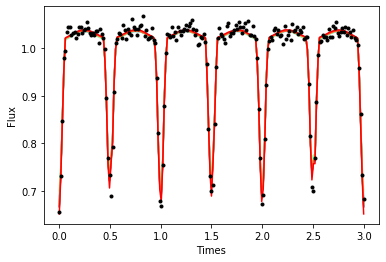

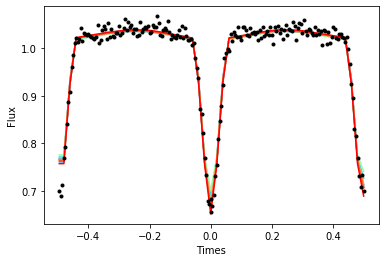

In [23]:
for i,c in zip(range(nwalkers),color):
    model = mod['fluxes@run{}'.format(i)].interp_value(times=times)

    pl.plot(times,model,c=c)

pl.xlabel("Times")
pl.ylabel("Flux")
pl.plot(times,noisy,"k.")
pl.show()

phases = mod.to_phase(times)
phases_sorted = sorted(phases)
for i,c in zip(range(nwalkers),color):
    model = mod['fluxes@run{}'.format(i)].interp_value(phases=phases_sorted)

    pl.plot(phases_sorted,model,c=c)

pl.xlabel("Times")
pl.ylabel("Flux")
pl.plot(phases,noisy,"k.")
pl.show()


